In [98]:
import torch
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning import loggers
from pytorch_lightning import Trainer
import numpy as np
import pandas as pd

from net import SimpleNet
from net_lstm import SimpleLSTM
from net_transformer import SimpleTimeSeriesTransformer

from datamodule import Datamodule
from model import FlightModel

from file_parsing_utils import create_csv_dict
from coordinate_transform import CoordinateEnum, helper_get_coordinate_system_based_on_enum
from iterate_flights import itterate_flights, build_features, flight_tensor_chunk_itterator
from model import iterative_path_predict
from coordinate_transform import  haversine

from glob import glob 
import copy
from collections import defaultdict

from folium_utils import create_folium_map
from folium_utils import get_map_image
import folium

from matplotlib import pyplot as plt
import matplotlib.image as mpimg


from iterate_flights import *

In [3]:
coordinate_system_enum = CoordinateEnum.LatLongCoordinates
coordinate_system = helper_get_coordinate_system_based_on_enum(coordinate_enum=coordinate_system_enum)

auxiliary_input_channels = [
                            "diff_time", 
                            "flight_course_corrected", 
                            "flight_course_unknown", 
                            ]

auxiliary_output_channels = []

len_coordinate_system  = len(coordinate_system)
desired_input_features = coordinate_system  + auxiliary_input_channels
desired_output_features = coordinate_system  + auxiliary_output_channels
desired_features_input_and_output = coordinate_system  + auxiliary_input_channels + auxiliary_output_channels

num_input_features = len(desired_input_features)
num_output_features = len(desired_output_features)

num_res_blocks = 4
intermediate_channels = 64
in_channels = len(coordinate_system) + len(auxiliary_input_channels)
out_channels = len(coordinate_system)





num_workers = 1

num_input_rows_total = 100
min_rows_input = 100
num_output_rows = 1

individual_flights_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/"
flight_dfs = create_csv_dict(individual_flights_dir)

datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = num_input_rows_total, 
                        min_rows_input = min_rows_input, 
                        num_output_rows = 1, 
                        coordinate_system_enum = coordinate_system_enum,
                        auxiliary_input_channels = auxiliary_input_channels,
                        auxiliary_output_channels = auxiliary_output_channels,
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = num_workers, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

# dummy tensor
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)

In [119]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from enum import Enum
from copy import deepcopy



import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def filter_df_by_aircraft_speed(df, speed_threshold = None):
    df['Altitude_m'] = df['Altitude'] * 30.48  # Convert altitude from 100s of feet to meters
    df['Latitude_shifted'] = df['Latitude'].shift()
    df['Longitude_shifted'] = df['Longitude'].shift()
    df['Altitude_m_shifted'] = df['Altitude_m'].shift()
    
    df['Distance_km'] = df.apply(lambda row: haversine(row['Latitude'], row['Longitude'], 
                                                       row['Latitude_shifted'], row['Longitude_shifted']), axis=1)
    df['Altitude_diff'] = (df['Altitude_m'] - df['Altitude_m_shifted']) / 1000  # Convert altitude difference to kilometers
    df['3D_Distance_km'] = np.sqrt(df['Distance_km']**2 + df['Altitude_diff']**2)  # 3D distance in kilometers
    df['Time_diff'] = df['Time'].diff() / 3600  # Convert time difference to hours
    df['Speed'] = df['3D_Distance_km'] / df['Time_diff']  # Speed in km/h
    
    if speed_threshold is not None:
        df = df[df['Speed'] >= speed_threshold]  # Filter rows based on speed threshold
    return df




class EnumInterpolate(Enum):
    LINEAR = 'linear'
    CUBIC = 'cubic'

def interpolate_flight_data(flight_df, method=EnumInterpolate.LINEAR):
    flight_df = flight_df.sort_values(by='Time')
    # Ensure 'Time' is the index
    flight_df.set_index('Time', inplace=True)
    
    # Create a new time range with 1-second intervals
    new_time_index = pd.RangeIndex(start=flight_df.index.min(), stop=flight_df.index.max() + 1, step=1)
    new_flight_df = flight_df.reindex(new_time_index)
    
    # Interpolate Latitude, Longitude, and Altitude
    if method == EnumInterpolate.LINEAR:
        new_flight_df[['Latitude', 'Longitude', 'Altitude']] = new_flight_df[['Latitude', 'Longitude', 'Altitude']].interpolate(method='linear')
    elif method == EnumInterpolate.CUBIC:
        for col in ['Latitude', 'Longitude', 'Altitude']:
            cs = CubicSpline(flight_df.index, flight_df[col])
            new_flight_df[col] = cs(new_time_index)
    
    # Forward fill auxiliary columns
    aux_columns = flight_df.columns.difference(['Latitude', 'Longitude', 'Altitude'])
    new_flight_df[aux_columns] = new_flight_df[aux_columns].fillna(method='ffill')
    
    # Reset index to make Time a column again
    new_flight_df.reset_index(inplace=True)
    new_flight_df.rename(columns={'index': 'Time'}, inplace=True)
    
    return new_flight_df

# # Sample DataFrame
# data = {
#     "Time": [1715979196, 1715979200, 1715979203, 1715979208, 1715979213, 1715979217, 1715979221],
#     "Latitude": [39.71753, 39.71675, 39.71603, 39.71486, 39.71369, 39.71264, 39.71167],
#     "Longitude": [-86.30675, -86.30786, -86.30878, -86.31039, -86.31200, -86.31350, -86.31486],
#     "Altitude": [1000, 1010, 1020, 1030, 1040, 1050, 1060],
#     "Aux1": ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
#     "Aux2": [1, 2, 3, 4, 5, 6, 7]
# }
# flight_df = pd.DataFrame(data)

# # Interpolate using linear method
# new_flight_df_linear = interpolate_flight_data(deepcopy(flight_df), method=EnumInterpolate.LINEAR)
# print(new_flight_df_linear)

# # Interpolate using cubic method
# new_flight_df_cubic = interpolate_flight_data(deepcopy(flight_df), method=EnumInterpolate.CUBIC)
# print(new_flight_df_cubic)



def simple_folium_map(some_flight_df):
    flightpath_compleate = some_flight_df[["Latitude", "Longitude"]].to_numpy()

    min_lat, max_lat = np.min(flightpath_compleate[:, 0]), np.max(flightpath_compleate[:, 0])
    min_long, max_long = np.min(flightpath_compleate[:, 1]), np.max(flightpath_compleate[:, 1])
    print("debug simple folium map: ", min_lat, min_long, max_lat, max_long)
    m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.03, tiles=None) #"Cartodb dark_matter")
    folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)
    return m



# m1 = simple_folium_map(flight_df)
# m2 = simple_folium_map(new_flight_df_linear)
# m3 = simple_folium_map(new_flight_df_cubic)


In [122]:
iter_flights = itterate_flights(flight_dfs, shuffle = True)
for flightseries in iter_flights:
    if flightseries is None:
        break

    (msn, flight_id), flight_df = flightseries 

    break

print(flight_df.shape)
#flight_df['Time'].diff().dropna()


m1 = simple_folium_map(flight_df)
m1

(1929, 13)
debug simple folium map:  32.67292 -117.19841 41.858 -87.74254


In [136]:
flight_df_copy = copy.deepcopy(flight_df)

flight_df_copy = filter_df_by_aircraft_speed(flight_df_copy, speed_threshold = 50.0)
flight_df_copy_linear = interpolate_flight_data(deepcopy(flight_df_copy), method=EnumInterpolate.LINEAR)

m2 = simple_folium_map(flight_df_copy_linear)
m2

debug simple folium map:  32.67292 -117.19784 41.858 -87.744


/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_10948/3258264060.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_flight_df[aux_columns] = new_flight_df[aux_columns].fillna(method='ffill')


Text(0, 0.5, 'Instances')

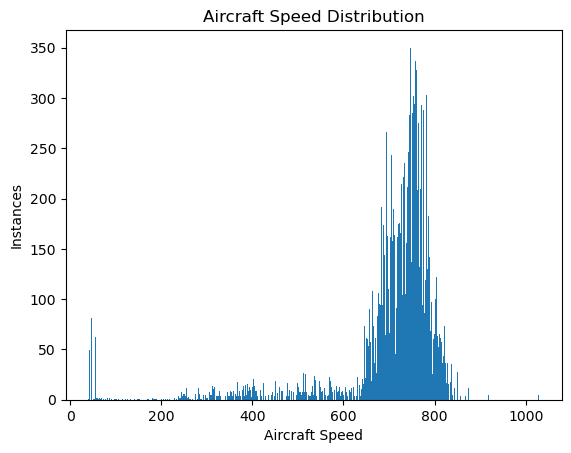

In [130]:
_ = plt.hist(flight_df_copy_linear['Speed'], bins=500)
plt.title("Aircraft Speed Distribution")
plt.xlabel("Aircraft Speed")
plt.ylabel("Instances")

Text(0, 0.5, 'Aircraft Speed (Km/Hour)')

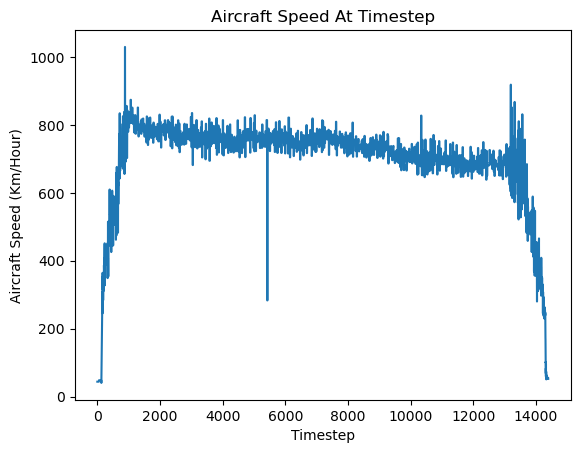

In [133]:
plt.figure()
plt.plot(flight_df_copy_linear['Speed'])
plt.title("Aircraft Speed At Timestep")
plt.xlabel("Timestep")
plt.ylabel("Aircraft Speed (Km/Hour)")

In [137]:
flight_df.shape, flight_df_copy_linear.shape

((1929, 13), (14265, 22))

Text(0, 0.5, 'Num Instances')

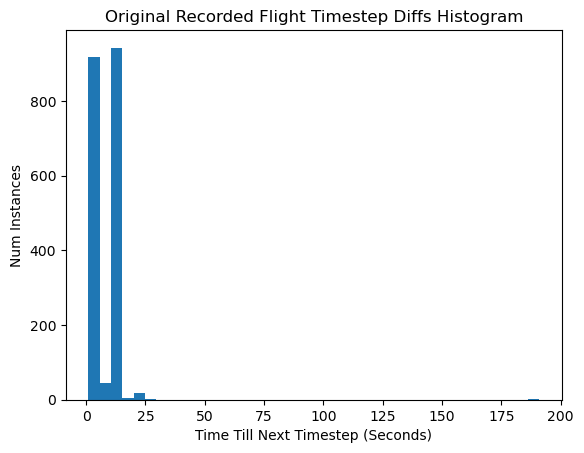

In [145]:
np_timesteps = flight_df['Time'].diff().dropna().to_numpy()
_= plt.hist(np_timesteps, bins=40)
plt.title("Original Recorded Flight Timestep Diffs Histogram")
plt.xlabel("Time Till Next Timestep (Seconds)")
plt.ylabel("Num Instances")

In [10]:
flight_df[["Time", "Latitude", "Longitude"]]

,Time,Latitude,Longitude
0,1715979196,39.71753,-86.30675
1,1715979200,39.71675,-86.30786
2,1715979203,39.71603,-86.30878
3,1715979208,39.71486,-86.31039
4,1715979213,39.71369,-86.31200
5,1715979217,39.71264,-86.31350
6,1715979221,39.71167,-86.31486
7,1715979226,39.71025,-86.31697
8,1715979231,39.70964,-86.31950
9,1715979235,39.70958,-86.32161


In [11]:
flight_df

,Unnamed: 0,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,98088373,150171,190,LTA941,1715979196,39.71753,-86.30675,11.0,AIG200,1,1,66,228
1,98088374,150171,190,LTA941,1715979200,39.71675,-86.30786,12.0,AIG200,1,6,66,228
2,98088375,150171,190,LTA941,1715979203,39.71603,-86.30878,12.0,AIG200,1,10,65,225
3,98088376,150171,190,LTA941,1715979208,39.71486,-86.31039,12.0,AIG200,1,10,73,227
4,98088377,150171,190,LTA941,1715979213,39.71369,-86.31200,12.0,AIG200,1,10,76,227
5,98088378,150171,190,LTA941,1715979217,39.71264,-86.31350,13.0,AIG200,1,3,77,228
6,98088379,150171,190,LTA941,1715979221,39.71167,-86.31486,13.0,AIG200,1,10,87,227
7,98088380,150171,190,LTA941,1715979226,39.71025,-86.31697,14.0,AIG200,1,1,83,229
8,98088381,150171,190,LTA941,1715979231,39.70964,-86.31950,14.0,AIG200,1,1,86,253
9,98088382,150171,190,LTA941,1715979235,39.70958,-86.32161,14.0,AIG200,1,4,85,268


In [85]:
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline
from enum import Enum
from copy import deepcopy



import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def filter_df_by_aircraft_speed(df, speed_threshold = None):
    df['Altitude_m'] = df['Altitude'] * 30.48  # Convert altitude from 100s of feet to meters
    df['Latitude_shifted'] = df['Latitude'].shift()
    df['Longitude_shifted'] = df['Longitude'].shift()
    df['Altitude_m_shifted'] = df['Altitude_m'].shift()
    
    df['Distance_km'] = df.apply(lambda row: haversine(row['Latitude'], row['Longitude'], 
                                                       row['Latitude_shifted'], row['Longitude_shifted']), axis=1)
    df['Altitude_diff'] = (df['Altitude_m'] - df['Altitude_m_shifted']) / 1000  # Convert altitude difference to kilometers
    df['3D_Distance_km'] = np.sqrt(df['Distance_km']**2 + df['Altitude_diff']**2)  # 3D distance in kilometers
    df['Time_diff'] = df['Time'].diff() / 3600  # Convert time difference to hours
    df['Speed'] = df['3D_Distance_km'] / df['Time_diff']  # Speed in km/h
    
    if speed_threshold is not None:
        df = df[df['Speed'] >= speed_threshold]  # Filter rows based on speed threshold
    return df




class EnumInterpolate(Enum):
    LINEAR = 'linear'
    CUBIC = 'cubic'

def interpolate_flight_data(flight_df, method=EnumInterpolate.LINEAR):
    flight_df = flight_df.sort_values(by='Time')
    # Ensure 'Time' is the index
    flight_df.set_index('Time', inplace=True)
    
    # Create a new time range with 1-second intervals
    new_time_index = pd.RangeIndex(start=flight_df.index.min(), stop=flight_df.index.max() + 1, step=1)
    new_flight_df = flight_df.reindex(new_time_index)
    
    # Interpolate Latitude, Longitude, and Altitude
    if method == EnumInterpolate.LINEAR:
        new_flight_df[['Latitude', 'Longitude', 'Altitude']] = new_flight_df[['Latitude', 'Longitude', 'Altitude']].interpolate(method='linear')
    elif method == EnumInterpolate.CUBIC:
        for col in ['Latitude', 'Longitude', 'Altitude']:
            cs = CubicSpline(flight_df.index, flight_df[col])
            new_flight_df[col] = cs(new_time_index)
    
    # Forward fill auxiliary columns
    aux_columns = flight_df.columns.difference(['Latitude', 'Longitude', 'Altitude'])
    new_flight_df[aux_columns] = new_flight_df[aux_columns].fillna(method='ffill')
    
    # Reset index to make Time a column again
    new_flight_df.reset_index(inplace=True)
    new_flight_df.rename(columns={'index': 'Time'}, inplace=True)
    
    return new_flight_df

# # Sample DataFrame
# data = {
#     "Time": [1715979196, 1715979200, 1715979203, 1715979208, 1715979213, 1715979217, 1715979221],
#     "Latitude": [39.71753, 39.71675, 39.71603, 39.71486, 39.71369, 39.71264, 39.71167],
#     "Longitude": [-86.30675, -86.30786, -86.30878, -86.31039, -86.31200, -86.31350, -86.31486],
#     "Altitude": [1000, 1010, 1020, 1030, 1040, 1050, 1060],
#     "Aux1": ['A', 'B', 'C', 'D', 'E', 'F', 'G'],
#     "Aux2": [1, 2, 3, 4, 5, 6, 7]
# }
# flight_df = pd.DataFrame(data)

# Interpolate using linear method
new_flight_df_linear = interpolate_flight_data(deepcopy(flight_df), method=EnumInterpolate.LINEAR)
print(new_flight_df_linear)

# Interpolate using cubic method
new_flight_df_cubic = interpolate_flight_data(deepcopy(flight_df), method=EnumInterpolate.CUBIC)
print(new_flight_df_cubic)


            Time  Unnamed: 0    fltKey    CID    UAID   Latitude   Longitude  \
0     1715885002  37417988.0  156862.0  881.0  DLX622  40.761940 -121.288890   
1     1715885003  37417988.0  156862.0  881.0  DLX622  40.761084 -121.288542   
2     1715885004  37417988.0  156862.0  881.0  DLX622  40.760228 -121.288195   
3     1715885005  37417988.0  156862.0  881.0  DLX622  40.759372 -121.287847   
4     1715885006  37417988.0  156862.0  881.0  DLX622  40.758517 -121.287500   
...          ...         ...       ...    ...     ...        ...         ...   
6894  1715891896  37418871.0  156862.0  881.0  DLX622  34.207903 -118.490280   
6895  1715891897  37418871.0  156862.0  881.0  DLX622  34.207732 -118.490280   
6896  1715891898  37418871.0  156862.0  881.0  DLX622  34.207562 -118.490280   
6897  1715891899  37418871.0  156862.0  881.0  DLX622  34.207391 -118.490280   
6898  1715891900  37418872.0  156862.0  881.0  DLX622  34.207220 -118.490280   

        Altitude PointSource  RecTypeCa

/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_10948/2270774101.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_flight_df[aux_columns] = new_flight_df[aux_columns].fillna(method='ffill')
/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_10948/2270774101.py:66: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  new_flight_df[aux_columns] = new_flight_df[aux_columns].fillna(method='ffill')


In [86]:
flight_df

,Unnamed: 0,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,37417988,156862,881,DLX622,1715885002,40.76194,-121.28889,151.0,TH_FIXM,1,1,192,163
1,37417989,156862,881,DLX622,1715885014,40.75167,-121.28472,153.0,TH_FIXM,1,10,192,163
2,37417990,156862,881,DLX622,1715885025,40.74194,-121.28083,154.0,TH_FIXM,1,8,198,163
3,37417991,156862,881,DLX622,1715885037,40.73139,-121.27667,156.0,TH_FIXM,1,10,197,163
4,37417992,156862,881,DLX622,1715885049,40.72056,-121.27222,159.0,TH_FIXM,1,8,202,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...
880,37418868,156862,881,DLX622,1715891861,34.21986,-118.49136,9.0,AIG200,1,1,99,175
881,37418869,156862,881,DLX622,1715891864,34.21833,-118.49139,10.0,TH_FIXM,1,1,132,181
882,37418870,156862,881,DLX622,1715891873,34.21333,-118.49083,9.0,TH_FIXM,1,1,120,175
883,37418871,156862,881,DLX622,1715891887,34.20944,-118.49028,9.0,TH_FIXM,1,1,60,173


In [87]:
new_flight_df_linear

,Time,Unnamed: 0,fltKey,CID,UAID,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,1715885002,37417988.0,156862.0,881.0,DLX622,40.761940,-121.288890,151.000000,TH_FIXM,1.0,1.0,192.0,163.0
1,1715885003,37417988.0,156862.0,881.0,DLX622,40.761084,-121.288542,151.166667,TH_FIXM,1.0,1.0,192.0,163.0
2,1715885004,37417988.0,156862.0,881.0,DLX622,40.760228,-121.288195,151.333333,TH_FIXM,1.0,1.0,192.0,163.0
3,1715885005,37417988.0,156862.0,881.0,DLX622,40.759372,-121.287847,151.500000,TH_FIXM,1.0,1.0,192.0,163.0
4,1715885006,37417988.0,156862.0,881.0,DLX622,40.758517,-121.287500,151.666667,TH_FIXM,1.0,1.0,192.0,163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6894,1715891896,37418871.0,156862.0,881.0,DLX622,34.207903,-118.490280,9.000000,TH_FIXM,1.0,1.0,60.0,173.0
6895,1715891897,37418871.0,156862.0,881.0,DLX622,34.207732,-118.490280,9.000000,TH_FIXM,1.0,1.0,60.0,173.0
6896,1715891898,37418871.0,156862.0,881.0,DLX622,34.207562,-118.490280,9.000000,TH_FIXM,1.0,1.0,60.0,173.0
6897,1715891899,37418871.0,156862.0,881.0,DLX622,34.207391,-118.490280,9.000000,TH_FIXM,1.0,1.0,60.0,173.0


In [88]:
flight_df.shape, new_flight_df_linear.shape, new_flight_df_cubic.shape

((885, 13), (6899, 13), (6899, 13))

Text(0, 0.5, 'Number of Steps')

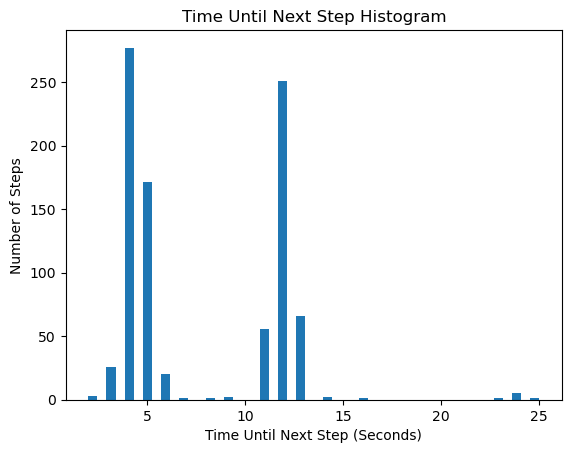

In [104]:
_ = plt.hist(flight_df['Time'].diff().dropna().to_numpy(), bins=50)
plt.title("Time Until Next Step Histogram")
plt.xlabel("Time Until Next Step (Seconds)")
plt.ylabel("Number of Steps")

1.0 1.0


Text(0, 0.5, 'Number of Steps')

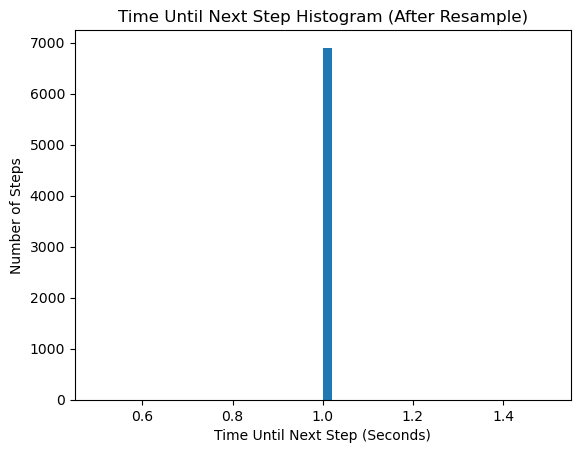

In [105]:
plt.hist(new_flight_df_linear['Time'].diff().dropna().to_numpy(), bins=50)
print(np.amin(new_flight_df_linear['Time'].diff().dropna().to_numpy()), np.amax(new_flight_df_linear['Time'].diff().dropna().to_numpy()))

plt.title("Time Until Next Step Histogram (After Resample)")
plt.xlabel("Time Until Next Step (Seconds)")
plt.ylabel("Number of Steps")

In [91]:
def simple_folium_map(some_flight_df):
    flightpath_compleate = some_flight_df[["Latitude", "Longitude"]].to_numpy()

    min_lat, max_lat = np.min(flightpath_compleate[:, 0]), np.max(flightpath_compleate[:, 0])
    min_long, max_long = np.min(flightpath_compleate[:, 1]), np.max(flightpath_compleate[:, 1])
    print("debug simple folium map: ", min_lat, min_long, max_lat, max_long)
    m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.03, tiles=None) #"Cartodb dark_matter")
    folium.PolyLine(locations=flightpath_compleate, color='black', weight=2.5, opacity=1).add_to(m)
    return m



m1 = simple_folium_map(flight_df)
m2 = simple_folium_map(new_flight_df_linear)
m3 = simple_folium_map(new_flight_df_cubic)


debug simple folium map:  34.20722 -121.28889 40.76194 -118.49028
debug simple folium map:  34.20722 -121.28889 40.76194 -118.49028
debug simple folium map:  34.20721999999999 -121.28889 40.76194 -118.49025849764159


(array([  13.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          14.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    8.,   10.,    9.,   10.,   11.,    8.,
           0.,   18.,   28.,   20.,   21.,   17.,    3.,   13.,   22.,
           0.,    4.,    0.,    8.,    0.,    0.,   10.,    5.,    0.,
           0.,   19.,    8.,   21.,   12.,   39.,   16.,   26.,   41.,
          17.,   22.,   45.,    4.,   28.,   41.,   47.,   47.,   25.,
          55.,   67.,  179.,  130.,  405.,  281.,  492.,  702.,  746.,
        1053.,  486.,  373.,  229.,  245.,  147.,   29.,   62.,   23.,
          41.,   55.,   23.,   13.,   20.,   28.,   23.,   29.,   20.,
          16.,   72.,   61.,   14.,   27.,    3.,   25.,    0.,    3.,
          11.]),
 array([ 68.35921952,  73.12482126,  77.890423  ,  82.65602474,
         87.42162648,  92.18722822,  96.95282996, 101.7184317 ,
        106.48403344, 111.24963518, 116.01523692, 120.78083867,
        12

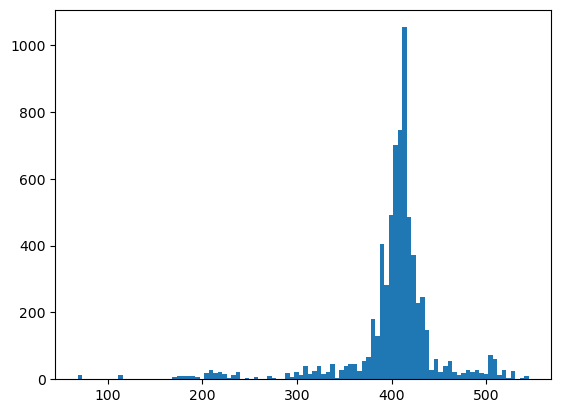

In [92]:
df_speed = filter_df_by_aircraft_speed(new_flight_df_linear, speed_threshold = None)
speed_np = df_speed[["Speed"]].to_numpy()

plt.hist(speed_np, bins=100)

speed_np_orig.shape:  (884, 1)


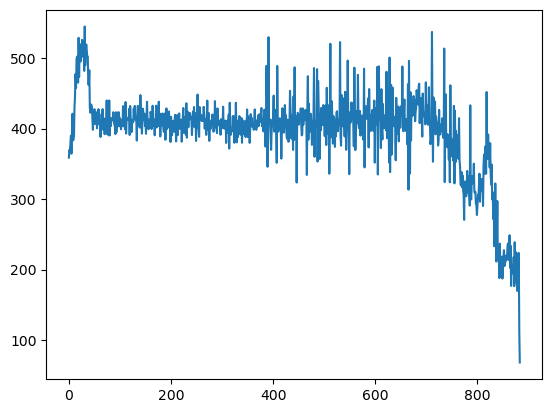

In [93]:
df_speed_orig = filter_df_by_aircraft_speed(flight_df, speed_threshold = 20.0)
speed_np_orig = df_speed_orig[["Speed"]].to_numpy()

print("speed_np_orig.shape: ", speed_np_orig.shape)
plt.figure()
plt.plot(speed_np_orig)

In [94]:
m2

In [95]:
m3

(array([5.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 4.000e+00, 3.000e+00,
        4.000e+00, 2.000e+00, 3.000e+00, 2.000e+00, 0.000e+00, 5.000e+00,
        4.000e+00, 3.000e+00, 3.000e+00, 1.000e+01, 1.400e+01, 3.200e+01,
        3.100e+01, 3.000e+01, 5.100e+01, 4.300e+01, 5.800e+01, 7.600e+01,
        8.400e+01, 1.090e+02, 1.760e+02, 1.850e+02, 2.670e+02, 3.780e+02,
        5.530e+02, 7.500e+02, 1.080e+03, 1.490e+03, 3.276e+03, 1.300e+03,
        1.023e+03, 7.550e+02, 5.380e+02, 4.120e+02, 2.810e+02, 1.940e+02,
        1.470e+02, 1.000e+02, 7.500e+01, 6.400e+01, 4.200e+01, 3.000e+01,
        2.500e+01, 1.100e+01, 1.200e+01, 8.000e+00, 6.000e+00, 8.000e+00,
        1.100e+01, 0.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

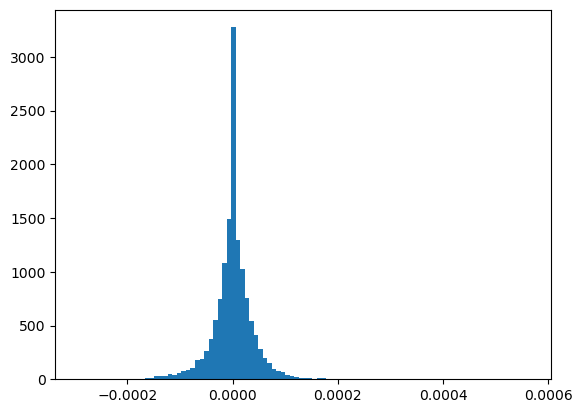

In [96]:
new_flight_df_linear_lat_long_np = new_flight_df_linear[['Latitude', 'Longitude']].to_numpy()
new_flight_df_cubic_lat_long_np = new_flight_df_cubic[['Latitude', 'Longitude']].to_numpy()

plt.hist(np.ndarray.flatten(new_flight_df_linear_lat_long_np - new_flight_df_cubic_lat_long_np), bins=100)

max alt:  176.0


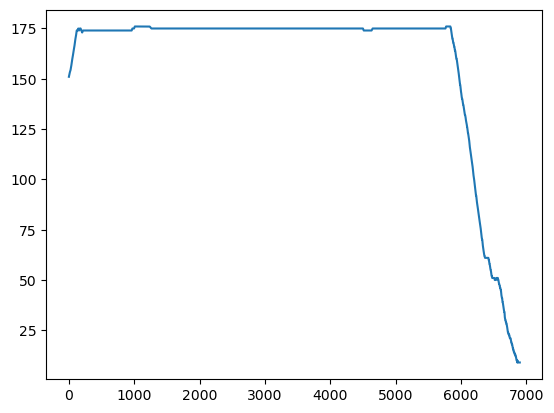

In [97]:
alt = new_flight_df_linear[['Altitude']].to_numpy()
plt.plot(alt)
print("max alt: ", np.amax(alt))

In [80]:
import pandas as pd
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # Radius of the Earth in kilometers
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

def filter_df_by_aircraft_speed(df, speed_threshold = None):
    df['Altitude_m'] = df['Altitude'] * 30.48  # Convert altitude from 100s of feet to meters
    df['Latitude_shifted'] = df['Latitude'].shift()
    df['Longitude_shifted'] = df['Longitude'].shift()
    df['Altitude_m_shifted'] = df['Altitude_m'].shift()
    
    df['Distance_km'] = df.apply(lambda row: haversine(row['Latitude'], row['Longitude'], 
                                                       row['Latitude_shifted'], row['Longitude_shifted']), axis=1)
    df['Altitude_diff'] = (df['Altitude_m'] - df['Altitude_m_shifted']) / 1000  # Convert altitude difference to kilometers
    df['3D_Distance_km'] = np.sqrt(df['Distance_km']**2 + df['Altitude_diff']**2)  # 3D distance in kilometers
    df['Time_diff'] = df['Timestamp'].diff().dt.total_seconds() / 3600  # Convert time difference to hours
    df['Plane_speed'] = df['3D_Distance_km'] / df['Time_diff']  # Speed in km/h
    
    if speed_threshold is not None;
        df = df[df['Plane_speed'] >= speed_threshold]  # Filter rows based on speed threshold
    return df

# Example usage
# Assuming 'df' is your DataFrame and 'speed_threshold' is the minimum speed
df = pd.DataFrame({
    'Latitude': [34.05, 36.12, 40.71],
    'Longitude': [-118.24, -115.17, -74.01],
    'Altitude': [300, 320, 340],  # in 100s of feet
    'Timestamp': pd.to_datetime(['2024-10-08 14:00:00', '2024-10-08 14:10:00', '2024-10-08 14:20:00'])
})

speed_threshold = 500  # Example speed threshold in km/h
df = filter_df_by_aircraft_speed(df, speed_threshold)
print(df)


SyntaxError: invalid syntax (2319062215.py, line 28)

In [81]:
450 * 3.28084

1476.378

In [52]:
450*100

45000

In [53]:
"""
This code finds the distance between two points: 

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the disance in kilometers from (lat1, lon1) to (lat2, lon2)
    """
    # Radius of the Earth in kilometers
    R = 6371.0

    # Convert latitude and longitude from degrees to radians
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    # Differences in coordinates
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Haversine formula
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    # Distance in kilometers
    distance = R * c

    return distance

I have a dataframe of an aircraft trajectory flightpath with the columns 'Latitude', 'Longitude' and 'Altitude'. I would like to create another column that is derived from this information, this column is "plane_speed"

the values in the Altitude column are measured in 100s of feet which may need to be converted to get  an accurate estimate of speed

finally I would like to filter out the dataframe from rows where the plane speed is below a certain value which is a parameter passed into the function
"""

IndentationError: unexpected indent (2055689172.py, line 6)

In [116]:
from collections import defaultdict
import os
import glob

def create_csv_dict2(dir_individual_flights):
    d = defaultdict(lambda: {})
    flight_folders = [f for f in os.listdir(dir_individual_flights) if os.path.isdir(os.path.join(dir_individual_flights, f))]
    
    for flight_folder in flight_folders:
        flight_folder_dir = os.path.join(dir_individual_flights, flight_folder)
        id_keys = [f for f in os.listdir(flight_folder_dir) if os.path.isdir(os.path.join(flight_folder_dir, f))]
        
        dict_ids = {id_key: glob.glob(os.path.join(flight_folder_dir, id_key, "*.csv"))[0] 
                    for id_key in id_keys if glob.glob(os.path.join(flight_folder_dir, id_key, "*.csv"))}
        
        if dict_ids:
            d[flight_folder] = dict_ids

    return d


from collections import defaultdict
import os
import glob

def create_csv_dict3(dir_individual_flights):
    d = defaultdict(lambda: {})
    for root, dirs, files in os.walk(dir_individual_flights):
        if files:
            csv_files = [f for f in files if f.endswith('.csv')]
            if csv_files:
                relative_path = os.path.relpath(root, dir_individual_flights)
                flight_folder, id_key = os.path.split(relative_path)
                if flight_folder and id_key:
                    d[flight_folder][id_key] = os.path.join(root, csv_files[0])
    return d



individual_flights_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/Individual_Flights/"

In [113]:

%timeit flight_dfs = create_csv_dict(individual_flights_dir)

15 s ± 1.08 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [114]:
%timeit flight_dfs2 = create_csv_dict2(individual_flights_dir)

17.9 s ± 80.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [117]:
%timeit flight_dfs3 = create_csv_dict3(individual_flights_dir)

14.5 s ± 129 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
